In [0]:
pip install yfinance

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yfinance as yf
import statsmodels.api as sm

In [0]:
STOCKS = [
    "AAPL", "NVDA", "MSFT", "AMZN", "META", "GOOGL", "AVGO", "TSLA", "GOOG",
    "BRK-B", "JPM", "LLY", "V", "UNH", "XOM", "COST", "MA", "WMT", "NFLX",
    "HD", "PG", "JNJ", "ABBV", "BAC", "CRM", "ORCL", "WFC", "CVX", "CSCO",
    "KO"
]
df = yf.download(STOCKS, start="2023-01-01", end="2023-12-31", interval="1d")

[*********************100%***********************]  30 of 30 completed


In [0]:
sp500 = yf.Ticker("^GSPC").history(start="2023-01-01", end="2023-12-31", interval="1d")

In [0]:
rf_history = yf.Ticker("^IRX").history(start="2023-01-01", end="2023-12-31", interval="1d")
rf_history['RiskFreeRate'] = rf_history['Close'] / 100
rf = rf_history['RiskFreeRate'].mean()

In [0]:
# Ensure float data type for each column
df = df.astype(float)

In [0]:
# Extract the closing price data
closing_prices = df['Close']

In [0]:
# Ensure float data type for SP500
sp500 = sp500.astype(float)
# Drop redundant columns
sp500 = sp500.iloc[:, 1:-2] 
# Extract the closing price for SP500
sp500_closing = sp500['Close'].values

In [0]:
# Daily return for each stock
daily_returns = closing_prices.pct_change().dropna()

# Correlation matrix
corr_matrix = daily_returns.corr()

# Covariance matrix
cov_matrix = daily_returns.cov()

In [0]:
# Simulation Parameters
num_simulations = 1000
forecast_days = 250
num_stocks_in_portfolio = 10

### SINGLE PROFOLIO SIMULATION

In [0]:
# Create a matrix for future updates
simulations = np.zeros((num_simulations, forecast_days))
returns = np.zeros((num_simulations, forecast_days))
drawdowns = np.zeros((num_simulations, forecast_days))
market_beta = np.zeros(num_simulations)

In [0]:
# Choose specific 10 stocks
np.random.seed(39)
selected_stocks = np.random.choice(daily_returns.columns, num_stocks_in_portfolio, replace=False)

# Find the return for the selected stocks
selected_returns = daily_returns[selected_stocks]
    
# Calculate the mean and covariance matrix for selected stocks
mu = selected_returns.mean()

# Extract the covariance matrix for the selected 10 stocks
selected_cov_matrix = cov_matrix.loc[selected_stocks, selected_stocks]
    
# Set Equal Weight 10% for each
weights = np.ones(num_stocks_in_portfolio) / num_stocks_in_portfolio

# Calculate the mean and standard deviation of the portfolio
portfolio_mu = np.dot(weights, mu)
portfolio_variance = np.dot(weights.T, np.dot(selected_cov_matrix, weights))
portfolio_sigma = np.sqrt(portfolio_variance)

# Get the last day's portfolio price
last_date = closing_prices.index[-1]  # Get the last trading day
last_price = closing_prices.loc[last_date, selected_stocks].dot(weights)  # Get the last portfolio price

In [0]:
selected_stocks

array(['META', 'XOM', 'ORCL', 'UNH', 'V', 'JNJ', 'HD', 'COST', 'ABBV',
       'AMZN'], dtype=object)

In [0]:
for i in range(num_simulations):
    # Generate returns for the next 365 days (normal distribution)
    random_returns = np.random.normal(portfolio_mu, portfolio_sigma, forecast_days)

    # Calculate the portfolio price for the next 365 days
    cumulative_returns = np.cumsum(random_returns)  # Calculate the cumulative rate of return
    future_prices = last_price * np.exp(cumulative_returns)  # Calculate the future price

    # Save simulation results
    simulations[i] = future_prices

    # Save returns
    returns[i] = random_returns

    # Save drawdowns
    peak = np.maximum.accumulate(future_prices)
    drawdowns[i] = (peak - future_prices)/peak

    # Calculate excess returns for portfolio and market:
    excess_portfolio = future_prices - rf
    excess_market = sp500_closing - rf

    # Prepare the independent & dependent variables for regression:
    X = sm.add_constant(excess_market)
    Y = excess_portfolio

    # Run the Ordinary Least Squares (OLS) regression & Save the beta value
    model = sm.OLS(Y, X)
    results = model.fit()
    market_beta[i] = results.params[1]

In [0]:
# Calculate the Average Return
average_return = np.mean(returns)

# Calculate the Average Volatility
average_volatility = np.std(returns)

# Calculate the Average Drawdown
average_drawdown = np.mean(drawdowns)

# Calculate the Average Beta
average_beta = np.mean(market_beta)

# Calculate the VaR99% of the portfolio
var99 = np.percentile(returns, 1)

# Calculate the Sharpe Ratio
sharpe_ratio = (average_return - rf) / average_volatility

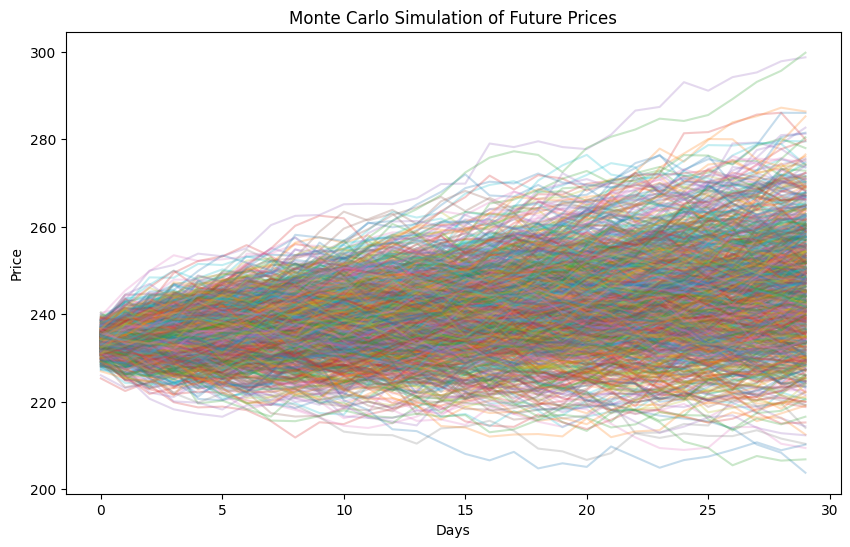

In [0]:
# Plot the simulation results
plt.figure(figsize=(10,6))
for i in range(num_simulations):
    plt.plot(simulations[i], alpha=0.25)
plt.title('Monte Carlo Simulation of Future Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

### 10 RANDOM PROFOLIO SIMULATIONS

In [0]:
# The number of stocks to be selected (should be 30045015 for total profolios)
num_outer_iterations = 10

In [0]:
# Create a set to store the selected combinations
selected_combinations = set()

# Create a list to store the metrics
metrics_list = []

for outer in range(num_outer_iterations):
    while True:
        # Random selection of stocks to ensure no duplicates
        selected_stocks = np.random.choice(daily_returns.columns, num_stocks_in_portfolio, replace=False)
        # Combinations are sorted and converted to tuples
        comb = tuple(sorted(selected_stocks))
        if comb not in selected_combinations:
            selected_combinations.add(comb)
            break

    # Create a matrix for future updates
    simulations = np.zeros((num_simulations, forecast_days))
    returns = np.zeros((num_simulations, forecast_days))
    drawdowns = np.zeros((num_simulations, forecast_days))
    market_beta = np.zeros(num_simulations)
    
    # Find the return for the selected stocks
    selected_returns = daily_returns[selected_stocks]

    # Calculate the mean and covariance matrix for selected stocks
    mu = selected_returns.mean()

    # Extract the covariance matrix for the selected 10 stocks
    selected_cov_matrix = cov_matrix.loc[selected_stocks, selected_stocks]
    
    # Set Equal Weight 10% for each
    weights = np.ones(num_stocks_in_portfolio) / num_stocks_in_portfolio

    # Calculate the mean and standard deviation of the portfolio
    portfolio_mu = np.dot(weights, mu)
    portfolio_variance = np.dot(weights.T, np.dot(selected_cov_matrix, weights))
    portfolio_sigma = np.sqrt(portfolio_variance)

    # Get the last day's portfolio price
    last_date = closing_prices.index[-1]  # Get the last trading day
    last_price = closing_prices.loc[last_date, selected_stocks].dot(weights)  # Get the last portfolio price

    # Save simulation results
    final_returns = np.zeros(num_simulations)
    volatilities = np.zeros(num_simulations)
    max_drawdowns = np.zeros(num_simulations)

    for i in range(num_simulations):
        # Generate returns for the next 365 days (normal distribution)
        random_returns = np.random.normal(portfolio_mu, portfolio_sigma, forecast_days)

        # Calculate the portfolio price for the next 365 days
        cumulative_returns = np.cumsum(random_returns)  # Calculate the cumulative rate of return
        future_prices = last_price * np.exp(cumulative_returns)  # Calculate the future price

        # Save simulation results
        simulations[i] = future_prices

        # Save returns
        returns[i] = random_returns

        # Save drawdowns
        peak = np.maximum.accumulate(future_prices)
        drawdowns[i] = (peak - future_prices)/peak

        # Calculate excess returns for portfolio and market:
        excess_portfolio = future_prices - rf
        excess_market = sp500_closing - rf

        # Prepare the independent & dependent variables for regression:
        X = sm.add_constant(excess_market)
        Y = excess_portfolio

        # Run the Ordinary Least Squares (OLS) regression & Save the beta value
        model = sm.OLS(Y, X)
        results = model.fit()
        market_beta[i] = results.params[1]

    # Calculate the Average Return
    avg_return = np.mean(returns)

    # Calculate the Average Volatility
    avg_volatility = np.std(returns)

    # Calculate the Average Drawdown
    avg_drawdown = np.mean(drawdowns)

    # Calculate the Average Beta
    avg_beta = np.mean(market_beta)

    # Calculate the VaR99% of the portfolio
    var99 = np.percentile(returns, 1)

    # Calculate the Sharpe Ratio
    sharpe_ratio = (avg_return - rf) / avg_volatility

    # Save all metrics into a list
    metrics_list.append({
        'selected_stocks': ','.join(comb), 
        'avg_return': avg_return,
        'avg_volatility': avg_volatility,
        'avg_drawdown': avg_drawdown,
        'avg_beta': avg_beta,
        'VaR99': var99,
        'sharpe_ratio': sharpe_ratio
    })

# Organize the results of all outer loops into a DataFrame table
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('selected_stocks', inplace=True)
metrics_df

,avg_return,avg_volatility,avg_drawdown,avg_beta,VaR99,sharpe_ratio
selected_stocks,,,,,,
"AAPL,CSCO,GOOG,GOOGL,META,MSFT,ORCL,TSLA,UNH,V",0.001855,0.011527,0.025707,0.153022,-0.025039,-4.215823
"BRK-B,COST,CRM,JNJ,JPM,MA,NVDA,PG,WFC,XOM",0.001339,0.008376,0.018838,0.101368,-0.018166,-5.863540
"BRK-B,COST,CSCO,CVX,GOOGL,JPM,MA,META,NVDA,PG",0.001661,0.009298,0.018915,0.136649,-0.019940,-5.247403
"AAPL,BRK-B,GOOG,GOOGL,JPM,META,NFLX,TSLA,WFC,WMT",0.001963,0.011683,0.025309,0.148922,-0.025199,-4.150553
"BAC,GOOG,GOOGL,KO,NFLX,NVDA,PG,TSLA,V,WMT",0.001715,0.010821,0.025133,0.093742,-0.023480,-4.504035
"ABBV,AMZN,CSCO,CVX,GOOG,HD,PG,TSLA,WFC,XOM",0.000999,0.009215,0.029782,0.046654,-0.020394,-5.366336
"AMZN,AVGO,COST,CSCO,GOOGL,JNJ,LLY,MSFT,NFLX,XOM",0.001544,0.009325,0.020559,0.142392,-0.020132,-5.244898
"AAPL,CRM,GOOGL,HD,META,NVDA,PG,TSLA,WMT,XOM",0.002173,0.011120,0.020574,0.145553,-0.023671,-4.341797
"AVGO,CSCO,GOOGL,JPM,META,MSFT,NFLX,TSLA,UNH,V",0.002038,0.011156,0.022050,0.193897,-0.023893,-4.339628


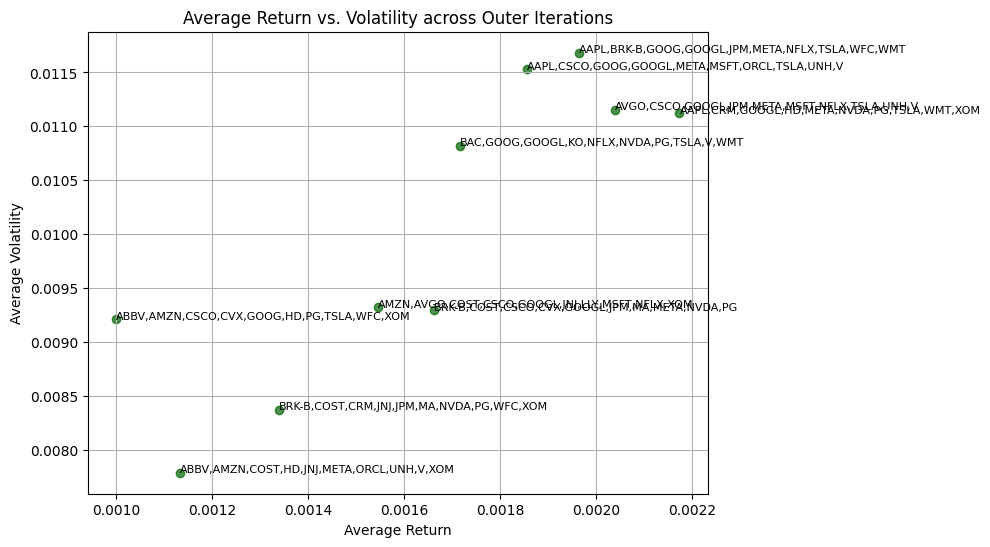

In [0]:
# Draw the scatter plot of the metrics for all outer loops
plt.figure(figsize=(8,6))
plt.scatter(metrics_df['avg_return'], metrics_df['avg_volatility'], color='darkgreen', alpha=0.7)
plt.xlabel("Average Return")
plt.ylabel("Average Volatility")
plt.title("Average Return vs. Volatility across Outer Iterations")
plt.grid(True)

# Note the selected combinations in the scatter plot
for comb, row in metrics_df.iterrows():
    plt.annotate(comb, (row['avg_return'], row['avg_volatility']), fontsize=8)

plt.show()

In [0]:
# Find the best portfolio combination based on the highest average return
best_combination = metrics_df['avg_return'].idxmax()
best_metrics = metrics_df.loc[best_combination]

print("Best portfolio combination:", best_combination)
print("Metrics for the best portfolio:\n", best_metrics)

Best portfolio combination: AAPL,CRM,GOOGL,HD,META,NVDA,PG,TSLA,WMT,XOM
Metrics for the best portfolio:
 avg_return        0.002173
avg_volatility    0.011120
avg_drawdown      0.020574
avg_beta          0.145553
VaR99            -0.023671
sharpe_ratio     -4.341797
Name: AAPL,CRM,GOOGL,HD,META,NVDA,PG,TSLA,WMT,XOM, dtype: float64


### Total PROFOLIO SIMULATIONS (30 CHOOSE 10)

In [0]:
import itertools

def generate_all_combinations_as_arrays(items, k):
    """
    Generator that yields all combinations of k items from the given list as NumPy arrays.
    """
    for combo in itertools.combinations(items, k):
        yield np.array(combo)

# Using the generator to iterate over all combinations:
combination_generator = generate_all_combinations_as_arrays(STOCKS, num_stocks_in_portfolio)

In [0]:
# Create a list to store the metrics
metrics_list = []

for selected_stocks in combination_generator:
    # Create a matrix for future updates
    simulations = np.zeros((num_simulations, forecast_days))
    returns = np.zeros((num_simulations, forecast_days))
    drawdowns = np.zeros((num_simulations, forecast_days))
    market_beta = np.zeros(num_simulations)
    
    # Find the return for the selected stocks
    selected_returns = daily_returns[selected_stocks]

    # Calculate the mean and covariance matrix for selected stocks
    mu = selected_returns.mean()

    # Extract the covariance matrix for the selected 10 stocks
    selected_cov_matrix = cov_matrix.loc[selected_stocks, selected_stocks]
    
    # Set Equal Weight 10% for each
    weights = np.ones(num_stocks_in_portfolio) / num_stocks_in_portfolio

    # Calculate the mean and standard deviation of the portfolio
    portfolio_mu = np.dot(weights, mu)
    portfolio_variance = np.dot(weights.T, np.dot(selected_cov_matrix, weights))
    portfolio_sigma = np.sqrt(portfolio_variance)

    # Get the last day's portfolio price
    last_date = closing_prices.index[-1]  # Get the last trading day
    last_price = closing_prices.loc[last_date, selected_stocks].dot(weights)  # Get the last portfolio price

    # Save simulation results
    final_returns = np.zeros(num_simulations)
    volatilities = np.zeros(num_simulations)
    max_drawdowns = np.zeros(num_simulations)

    for i in range(num_simulations):
        # Generate returns for the next 365 days (normal distribution)
        random_returns = np.random.normal(portfolio_mu, portfolio_sigma, forecast_days)

        # Calculate the portfolio price for the next 365 days
        cumulative_returns = np.cumsum(random_returns)  # Calculate the cumulative rate of return
        future_prices = last_price * np.exp(cumulative_returns)  # Calculate the future price

        # Save simulation results
        simulations[i] = future_prices

        # Save returns
        returns[i] = random_returns

        # Save drawdowns
        peak = np.maximum.accumulate(future_prices)
        drawdowns[i] = (peak - future_prices)/peak

        # Calculate excess returns for portfolio and market:
        excess_portfolio = future_prices - rf
        excess_market = sp500_closing - rf

        # Prepare the independent & dependent variables for regression:
        X = sm.add_constant(excess_market)
        Y = excess_portfolio

        # Run the Ordinary Least Squares (OLS) regression & Save the beta value
        model = sm.OLS(Y, X)
        results = model.fit()
        market_beta[i] = results.params[1]

    # Calculate the Average Return
    avg_return = np.mean(returns)

    # Calculate the Average Volatility
    avg_volatility = np.std(returns)

    # Calculate the Average Drawdown
    avg_drawdown = np.mean(drawdowns)

    # Calculate the Average Beta
    avg_beta = np.mean(market_beta)

    # Calculate the VaR99% of the portfolio
    var99 = np.percentile(returns, 1)

    # Calculate the Sharpe Ratio
    sharpe_ratio = (avg_return - rf) / avg_volatility

    # Save all metrics into a list
    comb = tuple(selected_stocks)  # The combination as a tuple
    metrics_list.append({
        'selected_stocks': ','.join(comb), 
        'avg_return': avg_return,
        'avg_volatility': avg_volatility,
        'avg_drawdown': avg_drawdown,
        'avg_beta': avg_beta,
        'VaR99': var99,
        'sharpe_ratio': sharpe_ratio
    })

# Organize the results of all outer loops into a DataFrame table
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('selected_stocks', inplace=True)

In [0]:
# Draw the scatter plot of the metrics for all outer loops
plt.figure(figsize=(8,6))
plt.scatter(metrics_df['avg_return'], metrics_df['avg_volatility'], color='darkgreen', alpha=0.7)
plt.xlabel("Average Return")
plt.ylabel("Average Volatility")
plt.title("Average Return vs. Volatility across Outer Iterations")
plt.grid(True)

# Note the selected combinations in the scatter plot
for comb, row in metrics_df.iterrows():
    plt.annotate(comb, (row['avg_return'], row['avg_volatility']), fontsize=8)

plt.show()

In [0]:
# Find the best portfolio combination based on the highest average return
best_combination_return = metrics_df['avg_return'].idxmax()
best_metrics_return = metrics_df.loc[best_combination]

# Find the best portfolio combination based on the highest average volatility
best_combination_volt = metrics_df['avg_volatility'].idxmax()
best_metrics_volt = metrics_df.loc[best_combination_volt]

# Find the best portfolio combination based on the highest average beta
best_combination_beta = metrics_df['avg_beta'].idxmax()
best_metrics_beta = metrics_df.loc[best_combination_beta]

# Find the best portfolio combination based on the highest Sharpe Ratio
best_combination_sharpe = metrics_df['sharpe_ratio'].idxmax()
best_metrics_sharpe = metrics_df.loc[best_combination_sharpe]

# Find the best portfolio combination based on the lowest maximum drawdown
best_combination_drawdown = metrics_df['avg_drawdown'].idxmin()
best_metrics_drawdown = metrics_df.loc[best_combination_drawdown]

# Find the best portfolio combination based on the lowest VaR99
best_combination_var99 = metrics_df['VaR99'].idxmin()
best_metrics_var99 = metrics_df.loc[best_combination_var99]

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:445)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:528)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:633)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:656)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:276)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
# Create a summary DataFrame
summary_data = {
    'Metric Category': [
        'Highest Average Return',
        'Highest Average Volatility',
        'Highest Average Beta',
        'Highest Sharpe Ratio',
        'Lowest Maximum Drawdown',
        'Lowest VaR99'
    ],
    'Best Combination': [
        best_combination_return,
        best_combination_volt,
        best_combination_beta,
        best_combination_sharpe,
        best_combination_drawdown,
        best_combination_var99
    ],
    'Metric Value': [
        best_metrics_return,
        best_metrics_volt,
        best_metrics_beta,
        best_metrics_sharpe,
        best_metrics_drawdown,
        best_metrics_var99
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Metric Category', inplace=True)
summary_df